In [ ]:
import spacy
import pandas as pd
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy.tokens import Doc
from spacy.util import minibatch, compounding
import nltk
nltk.download('vader_lexicon')
spacy.require_gpu()
nlp  = spacy.load('en_core_web_sm')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/StrawHats projects/News scraping.csv')
data.head()

Category  ...                                        Source Link
0   Sports  ...  https://indianexpress.com/article/sports/badmi...
1   Sports  ...  https://indianexpress.com/article/sports/badmi...
2   Sports  ...  https://indianexpress.com/article/sports/badmi...
3   Sports  ...  https://indianexpress.com/article/sports/badmi...
4   Sports  ...  https://indianexpress.com/article/sports/badmi...

[5 rows x 10 columns]

# Sentiment Analysis on the basis of positive or negitive impact made by the news items


We are doing the Sentiment analysis for our news items. The user will rate our news items on a scale of 0-5 depending on how positively or negatively impact the news have. A rating of 5 stands for the most positive news, and 0 stands for very negative news. 

We are using this Sentiment analysis technique to ensure that we don't hurt users' feelings if they seek positivity in the news items recommended by us.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(docx):
    return sent_analyzer.polarity_scores(docx.text)

Doc.set_extension("sentiment",getter=sentiment_scores)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
ex1 = nlp("This movie was very good, and I like it")
print(ex1._.sentiment)

{'neg': 0.0, 'neu': 0.502, 'pos': 0.498, 'compound': 0.7146}


In [ ]:
sia = SentimentIntensityAnalyzer()
a =  "This movie was very good, and I like it"
sia.polarity_scores(a)

{'compound': 0.7146, 'neg': 0.0, 'neu': 0.502, 'pos': 0.498}

In [ ]:
sia.polarity_scores(data.News[0])

{'compound': 0.8126, 'neg': 0.095, 'neu': 0.797, 'pos': 0.108}

In [ ]:
ex2 = nlp(data.News[0])
ex2._.sentiment

{'compound': 0.8126, 'neg': 0.095, 'neu': 0.797, 'pos': 0.108}

In [ ]:
data['scores'] = data['News'].apply(lambda news: sia.polarity_scores(news))
data['pos'] = data['scores'].apply(lambda dict: dict['pos'])
data['neg'] =data['scores'].apply(lambda dict: dict['neg'])
data['compound'] = data['scores'].apply(lambda dict: dict['compound'])
data['neutral'] = data['scores'].apply(lambda dict: dict['neu'])
data.head()

Category Sub_Category Language  ...    neg compound neutral
0   Sports    Badminton  English  ...  0.095   0.8126   0.797
1   Sports    Badminton  English  ...  0.074   0.2291   0.844
2   Sports    Badminton  English  ...  0.059   0.9956   0.832
3   Sports    Badminton  English  ...  0.021   0.9972   0.851
4   Sports    Badminton  English  ...  0.020   0.9909   0.852

[5 rows x 15 columns]

In [ ]:
import seaborn as sns


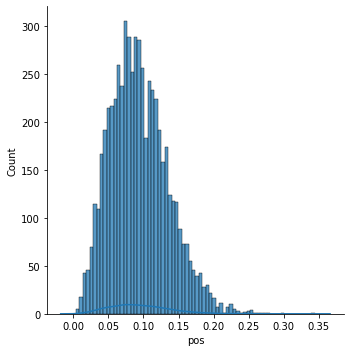

In [ ]:
sns.displot(data['pos'], bins = 70)
sns.kdeplot(data['pos'])


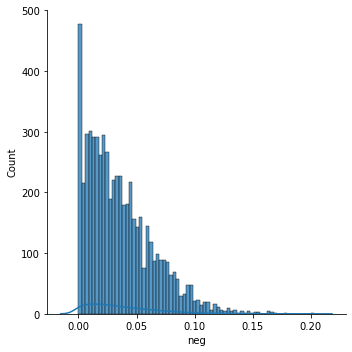

In [ ]:
sns.displot(data['neg'], bins = 70)
sns.kdeplot(data['neg'])


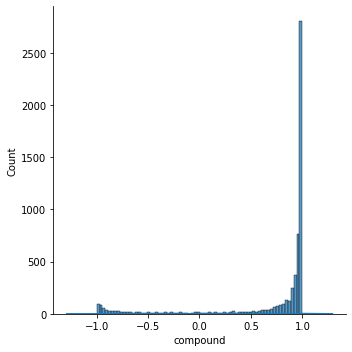

In [ ]:
sns.displot(data['compound'], bins = 70)
sns.kdeplot(data['compound'])


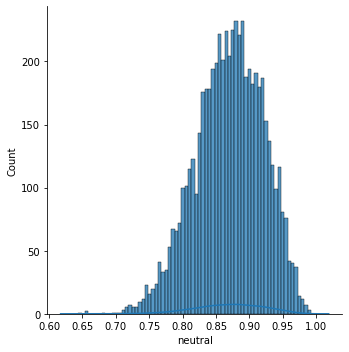

In [ ]:
sns.displot(data['neutral'], bins = 70)
sns.kdeplot(data['neutral'])


In [ ]:
print(data.describe())

               pos          neg     compound      neutral
count  5923.000000  5923.000000  5923.000000  5923.000000
mean      0.093913     0.036018     0.720775     0.870073
std       0.041574     0.028983     0.549844     0.050572
min       0.004000     0.000000    -0.999100     0.644000
25%       0.064000     0.013000     0.830600     0.836000
50%       0.090000     0.029000     0.967000     0.873000
75%       0.120000     0.053000     0.990900     0.908000
max       0.344000     0.203000     0.999900     0.992000


As we can see we are getting some good sentiment on the news but if we think for general public then sentiment analysis is not that good to do because as some people like some news and some dont so we should not think that our audience will accept news recommandations by using sentiment analysis. 

So we are dropping the idea of doing sentiment analysis in por model

#LDA Model


**Linear Discriminant Analysis(LDA)** is a dimensionality reduction technique used as a preprocessing step in Machine Learning and pattern classification applications. \\

The main objective of LDA is to reduce the dimensions by removing the inessential and dependent features by transforming the components from a higher dimensional space to a space with lower dimensions.

We tried to achieve success in this model by increasing the evaluation score called as Coherence score. We were able to make quite good progress on that but we found the method of Locality Sensitive hashing to be more useful and accurate. So, we used LSH technique later in this project. \\

Hear we are using pyLDAvis library to visualize teh data and get better idea of using LDA

In [ ]:
!pip install pyLDAvis==3.2.2

     |████████████████████████████████| 1.7MB 20.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=1bae2401efaba980abf9b489fb817fdffd2d825ccf6e9977b5e32cd63cc8a506
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [ ]:
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

We've done all the text pre prossesing to make a better model to evaluate

In [ ]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

#Cleantext for News
data['News'] = data['News'].apply(clean_text)
#cleantext for synopsis
data['Synopsis'] = data['Synopsis'].apply(clean_text)


In [ ]:
#Lets remove the common words
# Common word removal
common_words = pd.Series(' '.join(data['News']).split()).value_counts()[:50]
common_words = list(common_words.index)
data['News'] = data['News'].apply(lambda x: " ".join(x for x in x.split() if x not in common_words))
#common wordes removel for synopsis
common_words = pd.Series(' '.join(data['Synopsis']).split()).value_counts()[:50]
common_words = list(common_words.index)
data['Synopsis'] = data['Synopsis'].apply(lambda x: " ".join(x for x in x.split() if x not in common_words))


Hear we are generating our LDA model for 10 topics to get the idea of content NEWS

In [ ]:

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the News
data['news_without_stop']=data['News'].apply(remove_stopwords)



nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

text_list=data['news_without_stop'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)


carolina marin total played tournaments fewer sindhu four whole seasons that’s average less every airtravel hopping countries official tour’s media sponsorship commitments drain energy reservesmarin missed three yearend season finales either injury qualifying sindhu played four making finals winning players shuttle tournaments peak either quadrennial olympics annual championships marin made though she’s triple champion unarguably greatest female shuttler majors considered sindhu olympics three c’ships majors finals winning oncethe avoided marin group draw tour finals season finale begins wednesday sindhu ying chinese taipei home favourite ratchanok intanon pornpawee chochuwong sindhu’s nowhere near best expected olympics target want peak tokyonot getting injured marin away least months different injuries including serious might seem right curse overall break medical attention afford sindhu told espn recently shoulder overuse conditionthe fact hadn’t taken break countless niggles might’

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
lda_model.print_topics()


[(0,
  '0.028*"plan" + 0.022*"surface" + 0.020*"datum" + 0.019*"processor" + 0.015*"band" + 0.014*"technology" + 0.014*"index" + 0.012*"water" + 0.011*"scientist" + 0.009*"day"'),
 (1,
  '0.023*"business" + 0.018*"market" + 0.013*"growth" + 0.013*"sector" + 0.012*"sale" + 0.012*"company" + 0.012*"high" + 0.012*"bank" + 0.011*"rate" + 0.011*"month"'),
 (2,
  '0.019*"device" + 0.015*"technology" + 0.014*"available" + 0.013*"price" + 0.013*"good" + 0.012*"company" + 0.012*"display" + 0.010*"feature" + 0.010*"screen" + 0.009*"apple"'),
 (3,
  '0.035*"film" + 0.014*"investor" + 0.014*"point" + 0.013*"office" + 0.013*"week" + 0.011*"total" + 0.011*"analyst" + 0.011*"entertainment" + 0.010*"mobile" + 0.010*"dollar"'),
 (4,
  '0.036*"user" + 0.023*"flight" + 0.014*"airline" + 0.013*"space" + 0.013*"passenger" + 0.012*"mission" + 0.010*"earth" + 0.008*"travel" + 0.008*"country" + 0.007*"month"'),
 (5,
  '0.021*"player" + 0.017*"match" + 0.011*"woman" + 0.010*"good" + 0.009*"tournament" + 0.009*

As we can see hear we are getting some overlapping in topics so we will select optimal model by choosing number of topics.

In [ ]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.051992 -0.186010       1        1  20.268386
2     -0.050182 -0.011833       2        1  20.005380
1     -0.183082  0.050587       3        1  13.105076
6     -0.205499  0.086125       4        1  10.570398
4     -0.150037 -0.010159       5        1   8.387615
9      0.099985 -0.190587       6        1   7.302524
3      0.014775 -0.110937       7        1   6.639972
0      0.071501  0.297973       8        1   5.410255
8      0.261178  0.001326       9        1   5.236601
7      0.193352  0.073516      10        1   3.073793, topic_info=          Term         Freq        Total Category  logprob  loglift
1361     phone  2673.000000  2673.000000  Default  30.0000  30.0000
4297    camera  2053.000000  2053.000000  Default  29.0000  29.0000
7722    laptop  2007.000000  2007.000000  Default  28.0000  28.0000
8471      user  1933.000000  1933.000000  Default  27.0000  27.0000
9021   battery  1538.000000  1538.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
231      sport    77.315919   380.677652  Topic10  -5.5401   1.8882
508    weekend    73.341498   308.604241  Topic10  -5.5929   2.0453
7720  document    66.535240   166.045451  Topic10  -5.6903   2.5677
609    session    71.773880   407.763907  Topic10  -5.6145   1.7451
74      second    73.279162  2109.186860  Topic10  -5.5938   0.1225

[613 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
352        6  0.861637  10th
352       10  0.130332  10th
30915      9  0.992283  12mp
31287      9  0.993331  13mp
29381      9  0.993728  16mp
...      ...       ...   ...
663        5  0.108673     📣
663        6  0.073990     📣
663        7  0.080156     📣
663        8  0.033141     📣
663        9  0.014644     📣

[1148 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 7, 5, 10, 4, 1, 9, 8])

In [ ]:

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt


Perplexity:  -7.8471420061911825

Coherence Score:  0.5033278438070801


In this code we will compute coherance score for all the different models with different topics.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

As we can see the coherence score is not that good and by looking at the graph we can see that it is not stable we are not getting any good results by using news data for the LDA model.

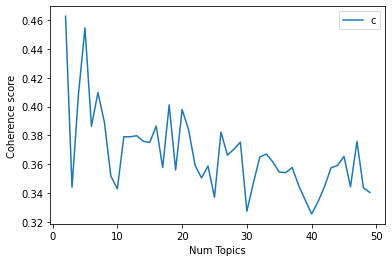

In [ ]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4626
Num Topics = 3  has Coherence Value of 0.3441
Num Topics = 4  has Coherence Value of 0.4089
Num Topics = 5  has Coherence Value of 0.4546
Num Topics = 6  has Coherence Value of 0.3864
Num Topics = 7  has Coherence Value of 0.4098
Num Topics = 8  has Coherence Value of 0.3892
Num Topics = 9  has Coherence Value of 0.3518
Num Topics = 10  has Coherence Value of 0.343
Num Topics = 11  has Coherence Value of 0.3791
Num Topics = 12  has Coherence Value of 0.3791
Num Topics = 13  has Coherence Value of 0.3798
Num Topics = 14  has Coherence Value of 0.376
Num Topics = 15  has Coherence Value of 0.3751
Num Topics = 16  has Coherence Value of 0.3865
Num Topics = 17  has Coherence Value of 0.3577
Num Topics = 18  has Coherence Value of 0.4012
Num Topics = 19  has Coherence Value of 0.356
Num Topics = 20  has Coherence Value of 0.398
Num Topics = 21  has Coherence Value of 0.384
Num Topics = 22  has Coherence Value of 0.3593
Num Topics = 23  has Coher

# Tuning our LDA model for better accuracy using Synopsis

In the last step, we obtained the coherence score of 0.3405 which was quite lower than what we expected. So, we tried to tune our LDA model to get better coherence score.

In [ ]:

# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.012*"phone" + 0.011*"technology" + 0.011*"device" + 0.008*"good" + 0.008*"company" + 0.007*"smartphone" + 0.006*"available" + 0.006*"apple" + 0.006*"audio" + 0.005*"price"'),
 (1,
  '0.007*"rate" + 0.007*"company" + 0.006*"phone" + 0.006*"price" + 0.005*"government" + 0.005*"growth" + 0.004*"business" + 0.004*"model" + 0.004*"datum" + 0.004*"system"'),
 (2,
  '0.024*"laptop" + 0.011*"company" + 0.007*"sector" + 0.007*"quarter" + 0.007*"business" + 0.006*"market" + 0.006*"technology" + 0.006*"high" + 0.005*"month" + 0.005*"good"'),
 (3,
  '0.016*"film" + 0.010*"device" + 0.008*"camera" + 0.008*"processor" + 0.008*"good" + 0.007*"display" + 0.007*"screen" + 0.005*"game" + 0.004*"phone" + 0.004*"space"'),
 (4,
  '0.008*"battery" + 0.008*"market" + 0.007*"high" + 0.007*"good" + 0.006*"match" + 0.005*"dollar" + 0.005*"woman" + 0.005*"moon" + 0.005*"business" + 0.005*"point"'),
 (5,
  '0.018*"user" + 0.012*"camera" + 0.010*"battery" + 0.010*"sensor" + 0.009*"display" + 0.007*"featu

So hear we have choosen best model with best coherance score.

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.003759 -0.040384       1        1  21.163266
3     -0.095172  0.040931       2        1  19.933260
1      0.071591 -0.026166       3        1  17.407327
4      0.015765  0.081598       4        1  16.289740
2      0.074400  0.004811       5        1  14.399960
5     -0.070343 -0.060790       6        1  10.806447, topic_info=             Term         Freq        Total Category  logprob  loglift
7722       laptop  2994.000000  2994.000000  Default  30.0000  30.0000
8706         film  2345.000000  2345.000000  Default  29.0000  29.0000
8471         user  2025.000000  2025.000000  Default  28.0000  28.0000
15644      sensor   946.000000   946.000000  Default  27.0000  27.0000
9021      battery  2341.000000  2341.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1115         full   195.961732  1140.782620   Topic6  -5.8673   0.4635
33           game   206.582828  1604.648098   Topic6  -5.8146   0.1751
3484   technology   233.061819  2955.260820   Topic6  -5.6940  -0.3150
923          case   191.809253  1213.474942   Topic6  -5.8888   0.3803
4890        price   195.425351  2397.637626   Topic6  -5.8701  -0.2820

[503 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
22463      5  0.142652     abort
22463      6  0.784585     abort
1205       1  0.128554  activity
1205       2  0.097452  activity
1205       3  0.441646  activity
...      ...       ...       ...
7734       2  0.686425      zoom
7734       3  0.019473      zoom
7734       4  0.019473      zoom
7734       5  0.004868      zoom
7734       6  0.136311      zoom

[1667 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 5, 3, 6])

If we think of synopsis which contain summery of the news so if we use it to make LDA model so we think that we can get some good results.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.157192  0.077798       1        1  10.952921
8      0.175124 -0.151649       2        1  10.828396
5     -0.154873 -0.149168       3        1  10.276387
7      0.067557  0.234499       4        1  10.227904
4     -0.054609 -0.022369       5        1  10.118411
3     -0.200096  0.092847       6        1  10.055220
0     -0.003301 -0.091927       7        1   9.715539
9     -0.096655  0.093456       8        1   9.467442
2      0.119703  0.004872       9        1   9.411597
1     -0.010041 -0.088359      10        1   8.946183, topic_info=          Term        Freq       Total Category  logprob  loglift
1346   company  181.000000  181.000000  Default  30.0000  30.0000
186       high  168.000000  168.000000  Default  29.0000  29.0000
2098      sale  150.000000  150.000000  Default  28.0000  28.0000
1097    laptop  126.000000  126.000000  Default  27.0000  27.0000
146       unit  121.000000  121.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
693    victory   19.209754   38.903835  Topic10  -5.1189   1.7083
3708  consumer   18.075735   27.277412  Topic10  -5.1797   2.0025
161      month   20.609474  164.769444  Topic10  -5.0485   0.3351
5         week   19.035886  130.526669  Topic10  -5.1279   0.4887
23      number   18.088795   77.627611  Topic10  -5.1790   0.9573

[478 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4459      2  0.413099  30share
4459     10  0.578339  30share
2988      1  0.559098  account
2988      5  0.259581  account
2988      8  0.099839  account
...     ...       ...      ...
184       2  0.641068     year
184       5  0.114163     year
184       7  0.122945     year
184       8  0.114163     year
264       7  0.973131    young

[660 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 6, 8, 5, 4, 1, 10, 3, 2])

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt


Perplexity:  -8.09453766321978

Coherence Score:  0.534445092354231


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=10, step=1)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

As we can see we are getting good coherance score just by changing our model to synopsis model we are getting some good coherance scores so now we can choose best model by selecting number of topics

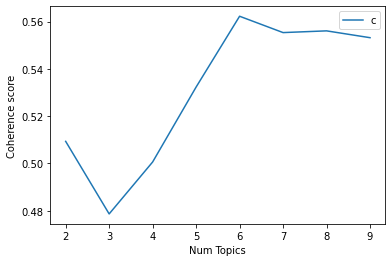

In [ ]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5093
Num Topics = 3  has Coherence Value of 0.4786
Num Topics = 4  has Coherence Value of 0.5006
Num Topics = 5  has Coherence Value of 0.5323
Num Topics = 6  has Coherence Value of 0.5622
Num Topics = 7  has Coherence Value of 0.5553
Num Topics = 8  has Coherence Value of 0.556
Num Topics = 9  has Coherence Value of 0.5532


In [ ]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.027*"laptop" + 0.023*"device" + 0.021*"high" + 0.015*"launch" + 0.015*"smartphone" + 0.012*"surface" + 0.010*"good" + 0.008*"stock" + 0.007*"live" + 0.007*"planet"'),
 (1,
  '0.010*"loan" + 0.009*"display" + 0.009*"list" + 0.008*"apple" + 0.008*"ground" + 0.008*"day" + 0.007*"budget" + 0.006*"smart" + 0.006*"regulatory" + 0.005*"unit"'),
 (2,
  '0.011*"business" + 0.010*"model" + 0.010*"large" + 0.009*"event" + 0.009*"screen" + 0.007*"range" + 0.006*"version" + 0.006*"small" + 0.005*"government" + 0.005*"platform"'),
 (3,
  '0.026*"company" + 0.021*"film" + 0.015*"sale" + 0.014*"today" + 0.012*"camera" + 0.010*"unit" + 0.010*"earth" + 0.010*"speaker" + 0.009*"available" + 0.008*"month"'),
 (4,
  '0.017*"good" + 0.014*"previous" + 0.013*"close" + 0.012*"phone" + 0.012*"sale" + 0.011*"wireless" + 0.011*"watch" + 0.011*"life" + 0.008*"deal" + 0.007*"experience"'),
 (5,
  '0.017*"plan" + 0.015*"battery" + 0.012*"feature" + 0.008*"total" + 0.008*"audio" + 0.007*"low" + 0.007*"look

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.097183 -0.032705       1        1  18.148114
2      0.043731 -0.026095       2        1  17.805292
3     -0.188068 -0.058391       3        1  17.778608
1      0.062428  0.021046       4        1  15.453891
5      0.018584 -0.090015       5        1  15.446325
4     -0.033858  0.186160       6        1  15.367770, topic_info=         Term        Freq       Total Category  logprob  loglift
1097   laptop  179.000000  179.000000  Default  30.0000  30.0000
1346  company  185.000000  185.000000  Default  29.0000  29.0000
2381   device  148.000000  148.000000  Default  28.0000  28.0000
2483     film  138.000000  138.000000  Default  27.0000  27.0000
186      high  164.000000  164.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
993      full   26.326912   69.682053   Topic6  -5.3447   0.8995
161     month   33.080543  142.349184   Topic6  -5.1164   0.4136
757     night   21.421060   43.260598   Topic6  -5.5509   1.1700
86     period   22.284907   51.477292   Topic6  -5.5114   1.0357
379      work   19.122123   46.049236   Topic6  -5.6645   0.9940

[357 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4459      1  0.250896  30share
4459      3  0.055755  30share
4459      4  0.055755  30share
4459      5  0.613302  30share
1923      5  0.956804   access
...     ...       ...      ...
184       2  0.197550     year
184       3  0.375346     year
184       4  0.276570     year
184       5  0.069143     year
184       6  0.079020     year

[628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 6, 5])

Hear we can see the contribution of the text towards perticualar model with keywords related to perticular model

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=doc_term_matrix, texts=tokenized_reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


Document_No  ...                                               Text
0            0  ...  [16th, defeat, meeting, ratchanok, humiliating...
1            1  ...             [match, player, break, wise, decision]
2            2  ...  [rankireddy, smash, kill, smash, manage, weapo...
3            3  ...  [number, pair, satwik, 36th, great, skill, tem...
4            4  ...                          [super, event, semifinal]
5            5  ...  [double, pairing, centrestage, satwikashwini, ...
6            6  ...  [unseeded, pair, hard, hour, minute, malaysian...
7            7  ...  [men, single, quarterfinal, tournament, steam,...
8            8  ...  [calm, game, much, effective, storm, cerebral,...
9            9  ...  [former, player, prannoy, game, outwit, sixth,...

[10 rows x 5 columns]

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  ...                                               Text
0        0.0  ...  [official, training, shoe, dining, room, home,...
1        1.0  ...  [busy, tradition, various, snuck, makeover, te...
2        2.0  ...  [early, lead, penalty, corner, specialist, gur...
3        3.0  ...  [german, filmmaker, hannsbruno, kammerton, fil...
4        4.0  ...  [nationwide, lockdown, curb, restriction, peop...
5        5.0  ...  [strict, enforcement, government, sop, absence...

[6 rows x 4 columns]

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(5)

Dominant_Topic  ... Perc_Documents
0.0             3.0  ...         0.1940
1.0             1.0  ...         0.1462
2.0             0.0  ...         0.1639
3.0             0.0  ...         0.1805
4.0             0.0  ...         0.1628

[5 rows x 4 columns]

At last we've realized that LDA model will be quiet have for computation and to make model and recommandations will be slow in terms of delevery and we can not get good recommandations with this model without having a lrge number of data.

So we droped the idea of LDA and we started using LSH model with NER which is giiving us quiet good results. and its really fast like for comparision LDA model take around 30 min of time to prepare even on google collab system but LSH model take only 11 sec to make MINhash forest for 6k data points and giving recommandations in just 0.009 sec which is extremly fast.